
# **<center><font style="color:rgb(100,109,254)">Human Action Recognition (CNN) UCF101</font> </center>**


In [1]:
# Discard the output of this cell.
# %%capture
# Install the required libraries.
!pip install tensorflow opencv-contrib-python

!pip install albumentaions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ERROR: Could not find a version that satisfies the requirement albumentaions (from versions: none)
ERROR: No matching distribution found for albumentaions


## **<font style="color:rgb(134,19,348)"> Outline </font>**

- **`Step 1:` Visualize the Data with its Labels**

- **`Step 2:` Preprocess the Dataset**

- **`Step 3:` Implement the model**
- **`Step 4:` Train and Val the model**


let's get started.

## **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [2]:
# Import the required libraries.
import os
import cv2 as cv

import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model,Model,Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import top_k_categorical_accuracy
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dropout
# from moviepy.editor import *
%matplotlib inline
import torch
# import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from torchviz import make_dot
from sklearn.model_selection import train_test_split

import pandas as pd

2024-06-11 08:03:18.208212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 08:03:18.208343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 08:03:18.339490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.


In [3]:
# tensorflow.__version__

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 1: Visualize the Data with its Labels</font>**

In the first step, we will visualize the data along with labels to get an idea about what we will be dealing with. We will be using the [UCF101 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF101.php), consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:

*   **`101`** Action Categories

*   **`25`** Groups of Videos per Action Category

*   **`133`** Average Videos per Action Category

*   **`199`** Average Number of Frames per Video

*   **`320`** Average Frames Width per Video

*   **`240`** Average Frames Height per Video

*   **`26`** Average Frames Per Seconds per Video

For visualization, we will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.

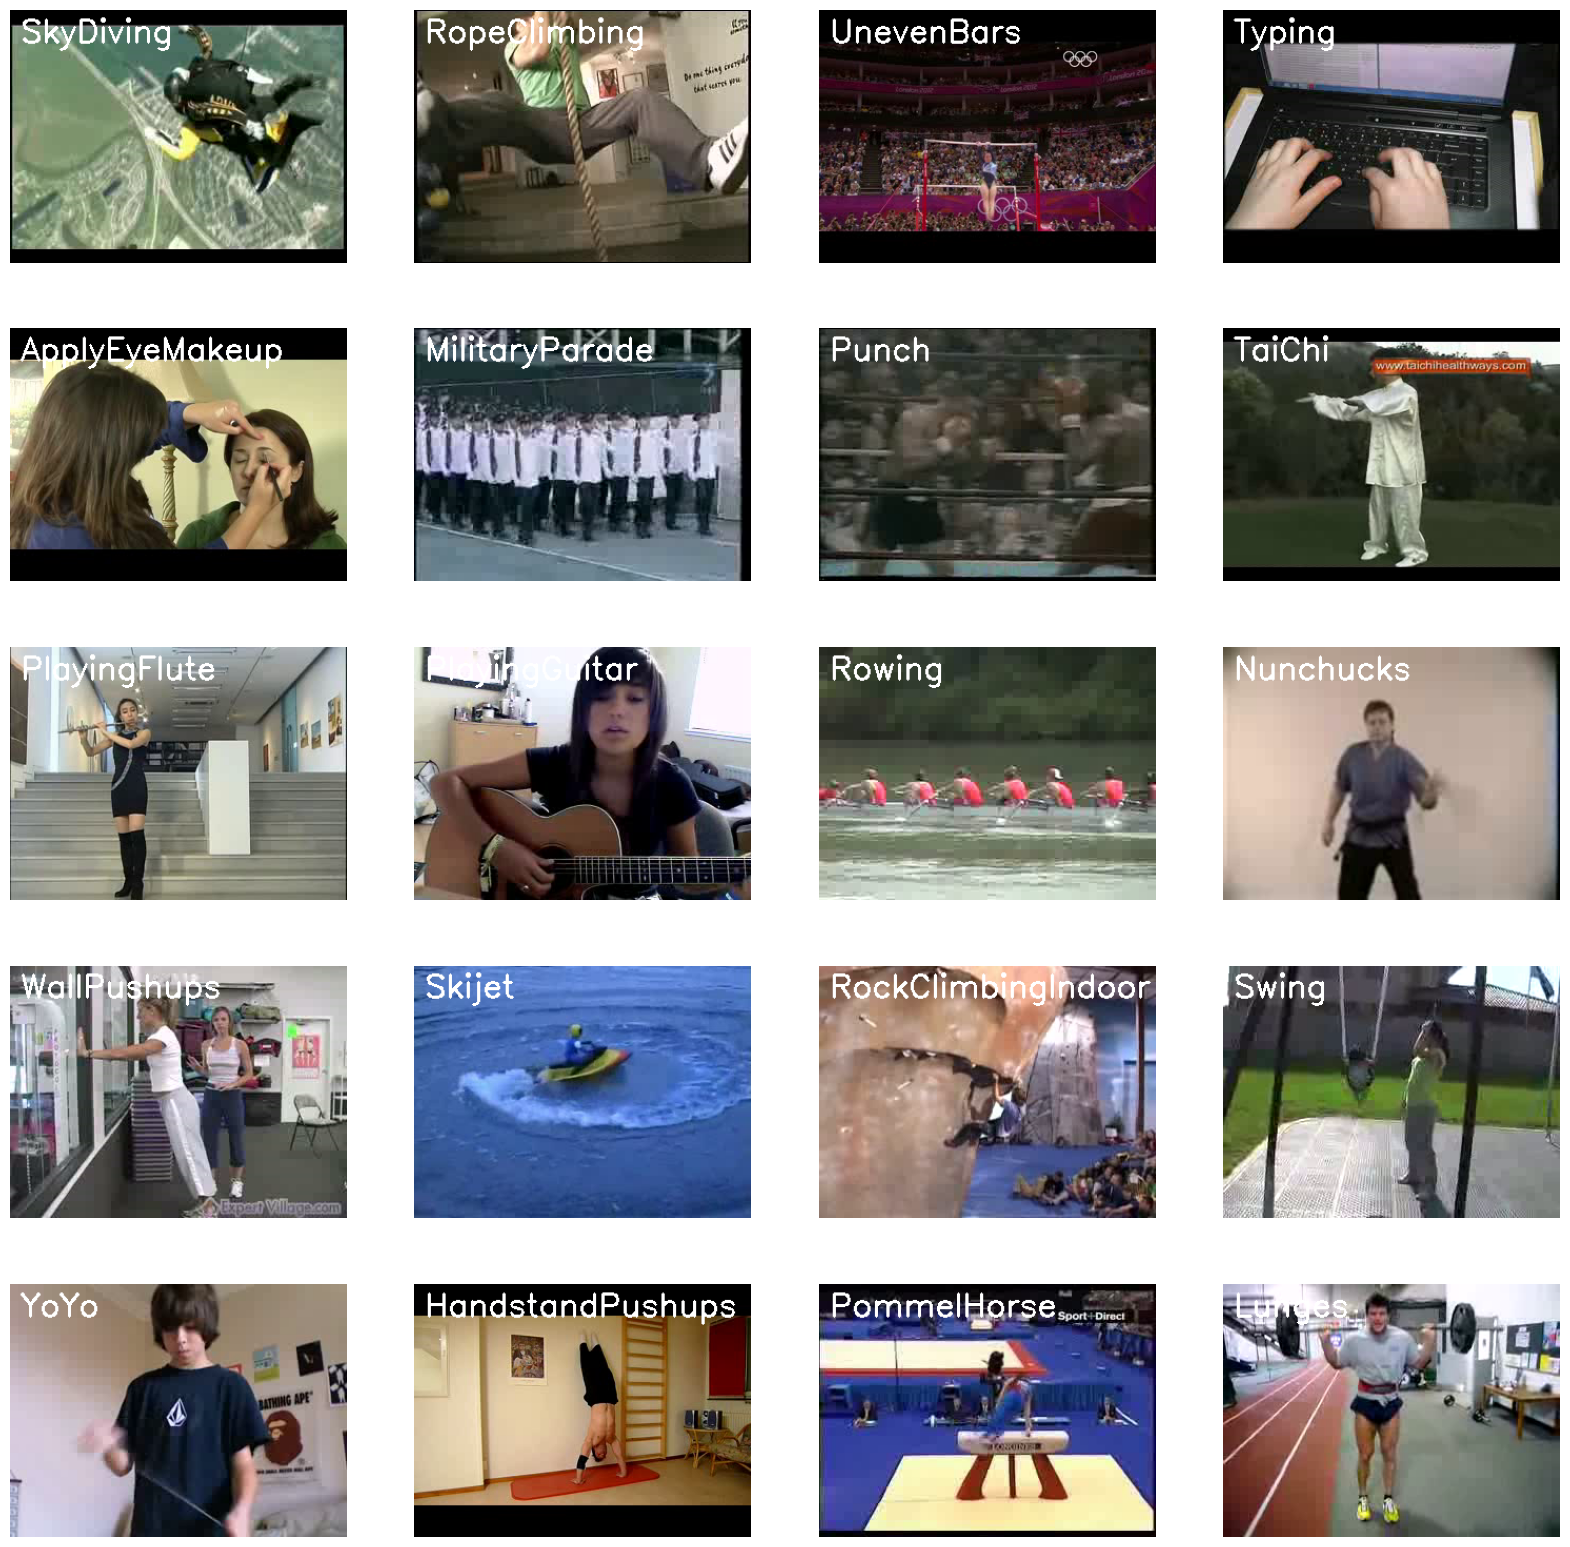

In [5]:
ucf101_root = '/kaggle/input/ucf101/UCF101/UCF-101/'

# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(ucf101_root)

# Generate a list of 20 random values. The values will be between 0-101, 
# where 101 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{ucf101_root}{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv.VideoCapture(f'{ucf101_root}{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv.cvtColor(bgr_frame, cv.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv.putText(rgb_frame, selected_class_Name, (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**


### **<font style="color:rgb(15, 214, 94)">2.1 Create a Function for Dataset Creation</font>**

Now we will create a function **`VideoDataset`** use torch
- *`video_dir`*: Đường dẫn tới thư mục chứa các video (video directory).
- *`trainTest_dir`*: Đường dẫn tới thư mục chứa tệp tin train/test (train/test split txt directory).
- *`classesIdx_txt`*: Đường dẫn tới tệp tin chứa danh sách các nhãn lớp (class index txt directory).
- *`mode`*: Chế độ của dataset, có thể là 'train' hoặc 'test'. Mặc định là 'train'.
- *`num_classes`*: Số lượng lớp cần sử dụng. Mặc định là 5.
- *`num_frames`*: Số lượng khung hình trong mỗi video. Mặc định là 50.
- *`transform`*: Hàm chuyển đổi dữ liệu cho các khung hình. Mặc định là None.
- *`target_transform`*: Hàm chuyển đổi nhãn lớp. Mặc định là None.

In [6]:
def read_video(video_path,transform,num_frames):
        # Proccessing video to frames and transform
    frames = []
    cap = cv.VideoCapture(video_path)#
    count_frames = 0
    while True:
        ret, frame = cap.read()
        if ret:
            if transform:
                transformed = transform(image = frame)
                frame = transformed['image'] 
            frames.append(frame)
            count_frames += 1
        else: 
            break
    stride = count_frames // num_frames
    if stride ==0:
        print(video_path)
        return []
    else: 
        new_frames = []
        count = 0
        for i in range(0, count_frames, stride):
            if count >= num_frames:
                break
            new_frames.append(frames[i])
            count += 1

        cap.release()
          
        return new_frames
    
def create_dataset(video_dir, trainTest_dir, classesIdx_txt, num_classes = 101,
                     num_frames = 30, transform = None, target_transform = None):   
    class_dict = {}
    with open(classesIdx_txt, 'r') as f:
        for line in f.readlines():
            classIdx, classLabel = line.split()
            class_dict[int(classIdx)] = classLabel
    labels=[]
    images=[]
    video_filename_list = []
    classesIdx_list = []
    with open(trainTest_dir, 'r') as f:
        for line in f.readlines():
            filename, Idx = line.split()
            if int(Idx) <= num_classes:
                video_filename_list.append(filename)
                classesIdx_list.append(int(Idx))
                
    for idx in range(len(video_filename_list)):
        classIdx = classesIdx_list[idx]
        classLabel = class_dict[classIdx]
        video_filename = video_filename_list[idx]
        video_path = os.path.join(video_dir, video_filename)
            
        frames = read_video(video_path,transform,num_frames)
        images.append(frames)
        labels.append(classIdx - 1)
        
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')


## **<font style="color:rgb(134,19,348)">Step 3: Implement models</font>** 

In [7]:
def CreateRNNModel(num_classes, num_frames, height, width):
    # Load pre-trained ResNet50 model + higher level layers
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))
    
    # Create input layer for the model
    input_layer = Input(shape=(num_frames, height, width, 3))

    # Pass input through TimeDistributed ResNet model
    reshaped_input = TimeDistributed(resnet_model)(input_layer)

    # Flatten the features
    flattened_features = TimeDistributed(Flatten())(reshaped_input)

    # Apply RNN layers
    rnn = SimpleRNN(32, return_sequences=True, activation='relu')(flattened_features)
    rnn_1 = SimpleRNN(64, return_sequences=True, activation='relu')(rnn)
    rnn_2 = SimpleRNN(128, return_sequences=True, activation='relu')(rnn_1)

    # Global average pooling to obtain a fixed-size representation
    pooled_features = tf.keras.layers.GlobalAveragePooling1D()(rnn_2)

    # Fully connected layers for classification
    dense_layer = Dense(128, activation='relu')(pooled_features)
    dropout_layer = Dropout(0.5)(dense_layer)
    output = Dense(num_classes, activation='softmax')(dropout_layer)

    # Create the model
    model = Model(inputs=input_layer, outputs=output)

    # Display the model summary
    model.summary()

    return model


## **<font style="color:rgb(134,19,348)">Step 4: Start Train and Val</font>** 

### **<font style="color:rgb(15, 214, 94)">Step 4.1: Initialize Variable</font>** 

In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def visualize_history(history, metrics = ['acc', 'loss']):   
    if 'acc' in metrics:
        plt.figure(figsize = (10,6))
        plt.subplot(121)
        plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'], label = 'train_acc', c = 'r')
        plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label = 'val_acc', c = 'g')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    if 'loss' in metrics:
        plt.subplot(122)
        plt.plot(range(1, len(history['loss']) + 1), history['loss'], label = 'train_loss', c = 'r')
        plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

In [9]:
classesIdx_txt = '/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt'
trainTest_dir = '/kaggle/input/ucf101-videolist/videolist.txt'
mode = 'train'
video_dir = '/kaggle/input/ucf101/UCF101/UCF-101'
best_weights = 'best_weights.keras'

# because issue out of memery so i choose only first 30 actions with full videos per action
num_classes =30
batch_size = 32
num_frames = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = (64,64)
num_workers = os.cpu_count()
print(device)

cuda


### **<font style="color:rgb(15, 214, 94)">Step 4.2: Initialize transform, Dataset, Dataloader</font>** 

In [10]:
transform = A.Compose(
    [
        A.Resize(height = img_size[0], width = img_size[1]),
        A.Normalize(),
        ToTensorV2()
    ]
)


images,labels = create_dataset(video_dir, trainTest_dir, classesIdx_txt, num_classes = num_classes, num_frames = num_frames, transform = transform)


In [11]:
images = np.transpose(images, (0, 1, 3, 4, 2))

images.shape, pd.Series(labels).shape

((4029, 30, 64, 64, 3), (4029,))

In [12]:
#Train Test Split
labels = to_categorical(labels)
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.2, shuffle = True, random_state=seed_constant)

x_train.shape , x_test.shape, y_train.shape


((3223, 30, 64, 64, 3), (806, 30, 64, 64, 3), (3223, 30))

### **<font style="color:rgb(15, 214, 94)">Step 4.3: Initialize Model, LossFunction, Optimizer, Scheduler</font>** 

In [13]:
model = CreateRNNModel(num_classes = num_classes, num_frames= num_frames, height = img_size[0], width = img_size[1])
#model = CreateSimpleRNNModel(num_classes = num_classes, num_frames= num_frames, height = img_size[0], width = img_size[1])
# model.build(input_shape=(batch_size, num_frames, img_size[0], img_size[1], 3))  # Assuming batch size is known
# model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 64, 64, 3)]   0         
                                                                 
 time_distributed (TimeDist  (None, 30, 2, 2, 2048)    23587712  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 8192)          0         
 stributed)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 30, 32)            263200    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 64)            6208      
                                                              

In [14]:
optimizer = Adam(learning_rate=0.00001)
top5_acc = top_k_categorical_accuracy
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',top5_acc,f1_m,precision_m, recall_m])

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * K.exp(-0.1)
lr_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint(best_weights, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
es = EarlyStopping(monitor='val_loss', patience=50, mode='min', restore_best_weights=True)


### **<font style="color:rgb(15, 214, 94)">Step 4.4: Train</font>** 

In [15]:

history = model.fit(x_train ,y_train, batch_size=batch_size, epochs=50, validation_split = 0.2, callbacks=[checkpoint, es, lr_scheduler])

Epoch 1/50


I0000 00:00:1718093357.413739   16322 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 [==============================] - ETA: 0s - loss: 3.5597 - accuracy: 0.0380 - top_k_categorical_accuracy: 0.1792 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 1: val_loss improved from inf to 3.50514, saving model to best_weights.keras
81/81 [==============================] - 120s 839ms/step - loss: 3.5597 - accuracy: 0.0380 - top_k_categorical_accuracy: 0.1792 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.5051 - val_accuracy: 0.0310 - val_top_k_categorical_accuracy: 0.1519 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/50
81/81 [==============================] - ETA: 0s - loss: 3.3462 - accuracy: 0.0625 - top_k_categorical_accuracy: 0.2459 - f1_m: 7.4822e-04 - precision_m: 0.0123 - recall_m: 3.8580e-04
Epoch 2: val_loss did not improve from 3.50514
81/81 [==============================] - 51s 630ms/step - loss: 3.3462 - accuracy: 0.0625 - top_k_categorical_a

### **<font style="color:rgb(15, 214, 94)">Step 4.5: Test</font>** 

In [17]:
test_metrics = model.evaluate(x_test, y_test)

26/26 [==============================] - 4s 141ms/step - loss: 1.1504 - accuracy: 0.7258 - top_k_categorical_accuracy: 0.8834 - f1_m: 0.6897 - precision_m: 0.9660 - recall_m: 0.5417


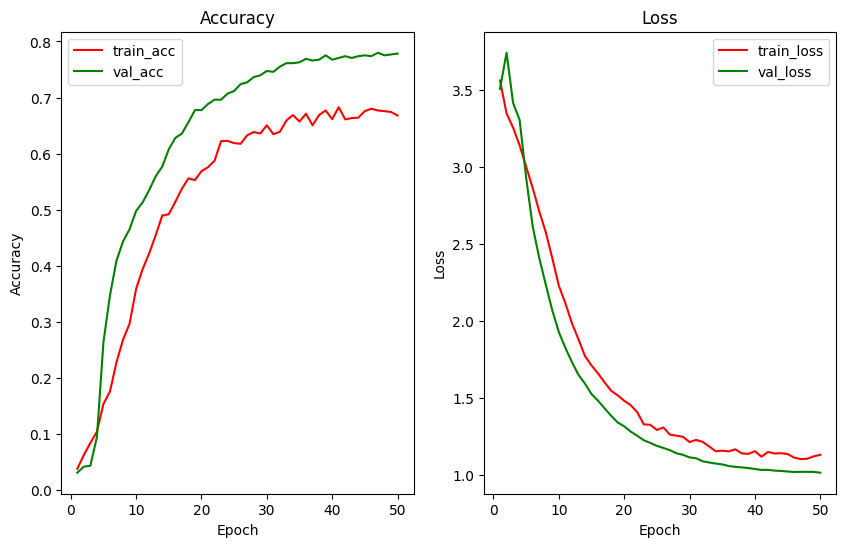

In [18]:
visualize_history(history.history)

In [ ]:
from sklearn.metrics import confusion_matrix
#Predict
y_prediction = model.predict(x_test)
# y_prediction = np.argmax (y_prediction, axis = 1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize=None)

# In ra confusion matrix
print("Confusion Matrix:")
print(result)

classesIdx_txt = '/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt'
# Tạo một từ điển ánh xạ từ tên lớp sang nhãn số
label_dict = {}
with open(classesIdx_txt, 'r') as f:
    for line in f:
        # Split dòng để lấy tên lớp và nhãn số
        idx, class_name = line.strip().split()
        # Lưu vào từ điển
        label_dict[int(idx)] = class_name


width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    result, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix 30 actions \n(normalised to % of total test data)")
plt.colorbar()
N = num_classes
tick_marks =np.arange(N)
plt.xticks(tick_marks, dict(list(label_dict.items())[0: N]).values(), rotation=90)
plt.yticks(tick_marks,dict(list(label_dict.items())[0: N]).values())
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')
plt.show()